In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [2]:
import joblib
import pandas as pd

data_kcat = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/kcat_with_features.joblib')
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,log10kcat_max,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [3]:
data_kcat.rename(columns={'log10kcat_max':'label'},inplace=True)
data_kcat.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,reactant_smiles,product_smiles,label,metabolite_features,protein_features
0,MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,sabio,Q05469,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O>>CCC(=O)O.CCC(...,7.00,3.1.1.1,0.845098,CCC(=O)OCC(COC(=O)CC)OC(=O)CC.O,CCC(=O)O.CCC(=O)OCC(CO)OC(=O)CC,0.845098,"[0.25240317, -0.45278314, -0.76844007, 0.04716...","[-0.06076221, -0.21264695, -0.05684641, 0.0163..."
1,MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...,brenda,Q71RI9,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,1.48,2.6.1.7,0.170262,Nc1ccccc1C(=O)C[C@H](N)C(=O)O.O=C(O)C(=O)Cc1cc...,N[C@@H](Cc1ccc(O)cc1)C(=O)O.O=C(O)c1cc(=O)c2cc...,0.170262,"[0.066915624, -0.15937805, -0.7076091, 0.12864...","[-0.051194582, -0.07116077, 0.16383636, 0.2113..."
2,MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...,brenda,A2SL37,C/C(=C\C=C(/O)C(=O)O)C(=O)O>>CC(/C=C/C(=O)C(=O...,3.40,5.3.2.6,0.531479,C/C(=C\C=C(/O)C(=O)O)C(=O)O,CC(/C=C/C(=O)C(=O)O)C(=O)O,2.029384,"[0.23911352, 0.011175589, -0.35101113, 0.15938...","[-0.1772431, -0.06500952, 0.18246448, -0.05431..."
3,MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...,brenda,Q9X015,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,0.69,3.6.1.9,-0.161151,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,N=c1nc(O)c2ncn([C@@H]3O[C@H](COP(=O)(O)OP(=O)(...,-0.161151,"[0.078591675, -0.15656142, -0.55292135, -0.245...","[-0.09246727, -0.033019878, 0.10869139, 0.2953..."
4,MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...,sabio,P0A7B1,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,420.00,2.7.4.1,2.623249,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O...,O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O...,2.623249,"[0.00051207165, -0.7151457, -0.95394605, -0.15...","[-0.06592023, -0.062496405, -0.012068139, 0.06..."


In [4]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_kcat, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(train_df['metabolite_features'], train_df['protein_features'])
])
train_y = train_df['label']
val_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(val_df['metabolite_features'], val_df['protein_features'])
])
val_y = val_df['label']
test_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(test_df['metabolite_features'], test_df['protein_features'])
])
test_y = test_df['label']

'''
from sklearn.model_selection import PredefinedSplit
split_index = [-1]*len(train_X) + [0]*len(val_X)
X = np.concatenate((train_X,val_X),axis=0)
y = np.concatenate((train_y,val_y),axis=0)
pds = PredefinedSplit(test_fold=split_index)
'''




'''
train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
'''

'\ntrain_dataset = MPI_Dataset(train_df)\nval_dataset = MPI_Dataset(val_df)\ntest_dataset = MPI_Dataset(test_df)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=32)\ntest_loader = DataLoader(test_dataset, batch_size=32)\n'

In [5]:
#model initialization
import xgboost as xg
xgb = xg.XGBRegressor()

In [6]:

'''
#Grid search
#ref: https://xgboost.readthedocs.io/en/stable/parameter.html
from sklearn.model_selection import GridSearchCV
param_grid = dict(
    max_depth = [5,10,15,20,None],
    n_estimators = [50,100,150,200]
)
regressor = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = pds, verbose = 3, n_jobs = -1)
'''

#Train the model
xgb.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [7]:
# Train
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr

y_train_pred = xgb.predict(train_X)

train_mse = mean_squared_error(train_y, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_y, y_train_pred)
train_r2 = r2_score(train_y, y_train_pred)
train_pearson_corr, _ = pearsonr(train_y, y_train_pred)
train_median_ae = median_absolute_error(train_y, y_train_pred)
train_explained_var = explained_variance_score(train_y, y_train_pred)

In [8]:
# Validation
y_val_pred = xgb.predict(val_X)

val_mse = mean_squared_error(val_y, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_y, y_val_pred)
val_r2 = r2_score(val_y, y_val_pred)
val_pearson_corr, _ = pearsonr(val_y, y_val_pred)
val_median_ae = median_absolute_error(val_y, y_val_pred)
val_explained_var = explained_variance_score(val_y, y_val_pred)

In [9]:
'''
#Choose the best model and test its performance

best_model = regressor.best_estimator_
best_params = regressor.best_params_
print('Best Hyperparameters:',best_params)
'''
# Test
y_test_pred = xgb.predict(test_X)

test_mse = mean_squared_error(test_y, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_y, y_test_pred)
test_r2 = r2_score(test_y, y_test_pred)
test_pearson_corr, _ = pearsonr(test_y, y_test_pred)
test_median_ae = median_absolute_error(test_y, y_test_pred)
test_explained_var = explained_variance_score(test_y, y_test_pred)


print(f"Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R-square: {test_r2:.4f}")

Test MSE: 1.3818, MAE: 0.8587, R-square: 0.5086


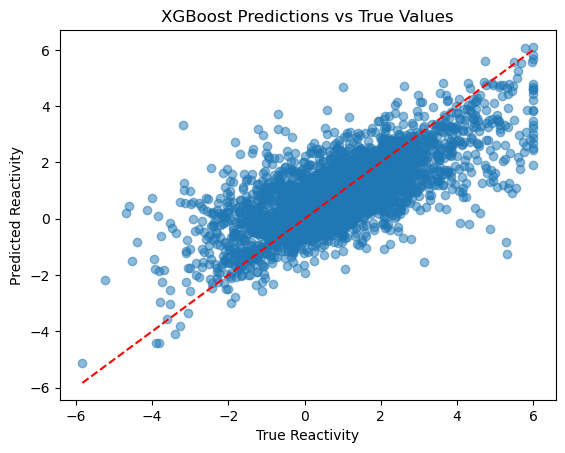

In [10]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_y, y_test_pred, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("XGBoost Predictions vs True Values")
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--')
plt.show()


In [11]:
# append the performance to the csv file
df = {
    'Model':['XGB','XGB','XGB'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('//Users/pinchichen/2025S lab/AI drug project/Catpred/model performance metrics_Catpred.csv', mode='a', header=False)

In [12]:
# save the model
from joblib import dump, load

dump(xgb, 'trained_model/random_split/XGBoost model_Catpred.joblib')

# load the model
#xgb_loaded = load('XGBoost model.joblib')

['trained_model/random_split/XGBoost model_Catpred.joblib']